# Пример обработки графических данных для классического машинного обучения
## Загрузка данных

Набор данных, который мы будем использовать, можно найти здесь (https://vcla.stat.ucla.edu/people/zhangzhang-si/HiT/exp5.html)

Разархивируйте данные в папку, к которой пропишем путь в `src`. Далее мы определяем функцию для чтения, изменения размера и сохранения данных в словаре, содержащем изображения, метки (названия животных), исходные имена файлов и описание. Сами изображения хранятся в виде массивов `numpy`, содержащих их значения `RGB`. Словарь сохраняется в файле `pickle` с помощью `joblib`. Структура данных основана на структуре, используемой для тестовых наборов данных в `scikit-learn`.

In [1]:
import joblib
from skimage.io import imread
from skimage.transform import resize
 
def resize_all(src, pklname, include, width=150, height=None):
     
    height = height if height is not None else width
     
    data = dict() # словарь, куда будем сохранять предобработанные данные
    data['description'] = f"resized ({int(width)}x{int(height)}) animal images in rgb"
    data['label'] = [] # список, куда будем собирать названия животных
    data['filename'] = [] # названия считанных файлов
    data['data'] = []    # сюда сохраняем изображения в формате numpy-массива
     
    pklname = f"{pklname}_{width}x{height}px.pkl"
 
    # считываем все изображения из PATH, изменяем размер и записываем в DESTINATION_PATH
    for subdir in os.listdir(src):
        if subdir in include:
            print(subdir)
            current_path = os.path.join(src, subdir)
 
            for file in os.listdir(current_path):
                if file[-3:] in {'jpg', 'png'}:
                    im = imread(os.path.join(current_path, file))
                    im = resize(im, (width, height)) #[:,:,::-1]
                    data['label'].append(subdir[:-4])
                    data['filename'].append(file)
                    data['data'].append(im)
 
        joblib.dump(data, pklname)

In [2]:
# определим путь до данных
import os

data_path = '../../data/AnimalFace/Image'
os.listdir(data_path)

['LionHead',
 'MouseHead',
 'DogHead',
 'BearHead',
 'Natural',
 'HumanHead',
 'ChickenHead',
 'PigHead',
 'PandaHead',
 'CatHead',
 'SheepHead',
 'DeerHead',
 'RabbitHead',
 'ElephantHead',
 'CowHead',
 'WolfHead',
 'MonkeyHead',
 'DuckHead',
 'EagleHead',
 'PigeonHead',
 'TigerHead']

Теперь мы создаем набор данных. Обратите внимание, что этот шаг не требуется каждый раз при запуске блокнота, поскольку данные хранятся в виде файла `pkl`, который можно загрузить напрямую в следующий раз.

В набор данных включено довольно много животных, но мы будем использовать только выборку, определенную ниже. Также мы устанавливаем ширину (и высоту) на `80 пикселей`.

In [3]:
base_name = 'animal_faces'
width = 80
 
include = {'ChickenHead', 'BearHead', 'ElephantHead', 
           'EagleHead', 'DeerHead', 'MonkeyHead', 'PandaHead'}
 
resize_all(src=data_path, pklname=base_name, width=width, include=include)

BearHead
ChickenHead
PandaHead
DeerHead
ElephantHead
MonkeyHead
EagleHead


Давайте загрузим данные с диска и распечатаем сводку.

In [5]:
import numpy as np
from collections import Counter
 
data = joblib.load(f'{base_name}_{width}x{width}px.pkl')
 
print('number of samples: ', len(data['data']))
print('keys: ', list(data.keys()))
print('description: ', data['description'])
print('image shape: ', data['data'][0].shape)
print('labels:', np.unique(data['label']))
 
Counter(data['label'])

number of samples:  716
keys:  ['description', 'label', 'filename', 'data']
description:  resized (80x80) animal images in rgb
image shape:  (80, 80, 3)
labels: ['Bear' 'Chicken' 'Deer' 'Eagle' 'Elephant' 'Monkey' 'Panda']


Counter({'Panda': 117,
         'Bear': 101,
         'Deer': 101,
         'Chicken': 100,
         'Elephant': 100,
         'Monkey': 100,
         'Eagle': 97})

На изображениях ниже показан пример каждого включенного животного.

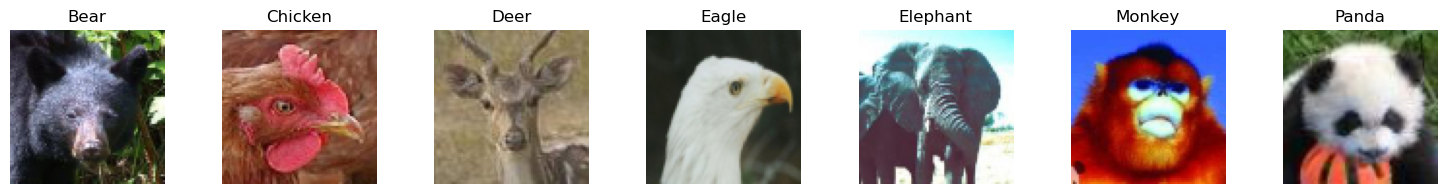

In [7]:
import matplotlib.pyplot as plt
labels = np.unique(data['label'])
 
fig, axes = plt.subplots(1, len(labels))
fig.set_size_inches(15,4)
fig.tight_layout()
 
for ax, label in zip(axes, labels):
    idx = data['label'].index(label)
     
    ax.imshow(data['data'][idx])
    ax.axis('off')
    ax.set_title(label)

По соглашению, мы называем входные данные $X$, а результат (метки) $y$.

In [8]:
X = np.array(data['data'])
y = np.array(data['label'])

Далее нам нужно разделить наши данные на тестовый набор и обучающий набор. Мы используем функцию `train_test_split` из `scikit-learn` и используем 80% общего набора для обучения, а оставшееся — для тестового набора. В наборе данных фотографии упорядочены по животным, поэтому мы не можем просто разделить их по 80%.

Чтобы понять почему, давайте посмотрим на таблицу ниже. Если данные упорядочены и мы разделили их в какой-то позиции, в итоге некоторые животные (типы) появятся только в одном из двух наборов. Например, коровы появляются только в тестовом наборе. Это проблема, так как таким образом мы никогда не научим нашу модель распознавать коров, и, следовательно, она не сможет их правильно предсказать.

Мы можем решить эту проблему, перетасовав данные перед разделением. Таким образом мы выравниваем распределения в обучающем и тестовом наборах и делаем их сопоставимыми.

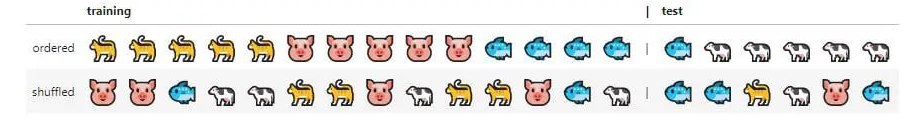

Функция `train_test_split` в `sklearn` предоставляет параметр перемешивания, который позаботится об этом при разделении. `random_seed` определяет перетасовку так, чтобы она была случайной, но воспроизводимой.

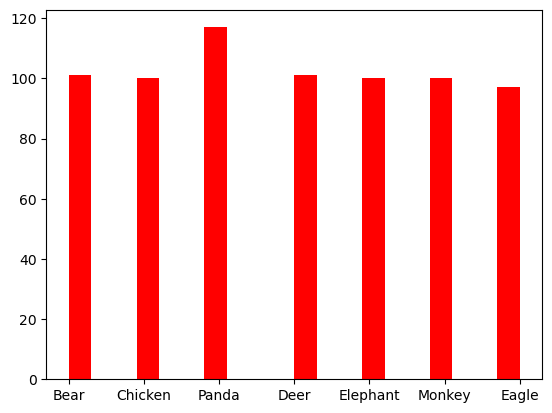

In [9]:
plt.hist(y, color='red', bins=20);

Данные почти сбалансированы.

In [10]:
from sklearn.model_selection import train_test_split
 
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    shuffle=True,
    random_state=42,
    stratify=y
)

Чтобы убедиться в схожести распределения фотографий в обучающей и тестовой выборках, давайте посмотрим на относительное количество фотографий в каждой категории.

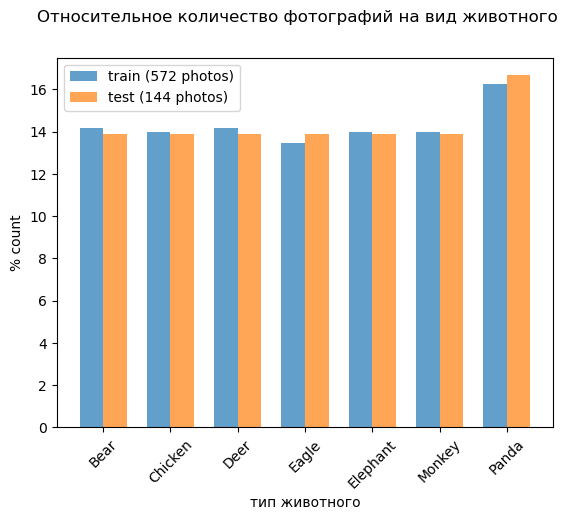

In [11]:
def plot_bar(y, loc='left', relative=True):
    width = 0.35
    if loc == 'left':
        n = -0.5
    elif loc == 'right':
        n = 0.5
     
    unique, counts = np.unique(y, return_counts=True)
    sorted_index = np.argsort(unique)
    unique = unique[sorted_index]
     
    if relative:
        counts = 100*counts[sorted_index]/len(y)
        ylabel_text = '% count'
    else:
        counts = counts[sorted_index]
        ylabel_text = 'count'
         
    xtemp = np.arange(len(unique))
     
    plt.bar(xtemp + n*width, counts, align='center', alpha=.7, width=width)
    plt.xticks(xtemp, unique, rotation=45)
    plt.xlabel('тип животного')
    plt.ylabel(ylabel_text)
    plt.suptitle('Относительное количество фотографий на вид животного')
plot_bar(y_train, loc='left')
plot_bar(y_test, loc='right')
plt.legend([
    f"train ({len(y_train)} photos)", 
    f"test ({len(y_test)} photos)"
]);

Распределения не совсем равны, но на данный момент достаточно хороши. Обратите внимание, что наш набор данных довольно мал (~ 100 фотографий на категорию), поэтому разница в 1 или 2 фотографии в тестовом наборе будет иметь большое влияние на распределение. Поэтому мы использовали параметр `stratify в train_test_split`, чтобы обеспечить равное распределение в обучающем и тестовом наборах.

## Преподготовка данных
Классическим подходом к распознаванию объектов является `HOG-SVM`, что означает `гистограмма ориентированных градиентов и машин опорных векторов`. `HOG` используются для сокращения параметров, другими словами: для снижения сложности проблемы, сохраняя при этом как можно больше вариаций.

Для расчета `HOG` изображение разбивается на блоки, например 8 на 8 пикселей. Для каждого из этих блоков рассчитывается величина градиента в заданном количестве направлений.

Посмотрим на пример с изображением не из наших данных.

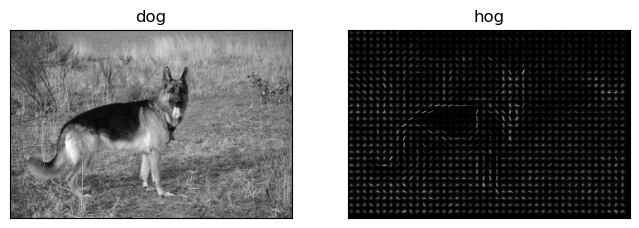

In [12]:
from skimage.feature import hog
from skimage.io import imread
from skimage.transform import rescale
 
dog = imread('../../data/test_dog.jpg', as_gray=True)
 
# уменьшим изображение до одной третьей
dog = rescale(dog, 1/3, mode='reflect')
# вычислить hog и вернуть визуальное представление.
dog_hog, dog_hog_img = hog(
    dog, pixels_per_cell=(8, 8), 
    cells_per_block=(2, 2), 
    orientations=9, 
    visualize=True, 
    block_norm='L2-Hys')
 
fig, ax = plt.subplots(1,2)
fig.set_size_inches(8,6)
[a.tick_params(bottom=False, left=False, labelbottom=False, labelleft=False) 
    for a in ax]
 
ax[0].imshow(dog, cmap='gray')
ax[0].set_title('dog')
ax[1].imshow(dog_hog_img, cmap='gray')
ax[1].set_title('hog')
plt.show()

In [13]:
print('number of pixels: ', dog.shape[0] * dog.shape[1])
print('number of hog features: ', dog_hog.shape[0])

number of pixels:  77748
number of hog features:  39852


Количество точек данных, которые необходимо обработать в нашей модели, сократилось примерно вдвое, и при некотором воображении мы все еще можем распознать собаку в `HOG`. Этот приём используется, если признаков слишком много и их больше, чем образцов данных.

Такое же можно использовать на наборе данных `MNIST`: вместо отдельных пикселей можно построить гистограмму градиентов и попробовать на ней обучить модель.

При расчете нашего `HOG` мы выполнили преобразование. Мы можем преобразовать весь наш набор данных с помощью `трансформеров`. Это объекты, которые принимают массив данных, преобразуют каждый элемент и возвращают обработанные данные.

Здесь нам нужно преобразовать цветные изображения в оттенки серого, вычислить их `HOG` и, наконец, масштабировать данные. Для этого мы используем три преобразователя подряд: `RGB2GrayTransformer`, `HOGTransformer` и `StandardScaler`. Конечным результатом является массив с `HOG` для каждого входного изображения.

`Scikit-learn` поставляется со множеством встроенных трансформеров, таких как `StandardScaler` для масштабирования признаков и `Binarizer` для сопоставления строковых функций с числовыми функциями. Кроме того, он предоставляет классы `BaseEstimator` и `TransformerMixin` для облегчения создания собственных трансформеров.

Пользовательский трансформер можно создать, унаследовав эти два класса и реализовав метод `__init__`, `fit` и `transform`. Класс `TransformerMixin` предоставляет метод `fit_transform`, который сочетает в себе реализованную нами подгонку и преобразование.

Ниже мы определяем `RGB2GrayTransformer` и `HOGTransformer`.

In [14]:
from sklearn.base import BaseEstimator, TransformerMixin
 
class RGB2GrayTransformer(BaseEstimator, TransformerMixin):
    """
    Преобразует цветное RGB изображение в изображение в оттенках серого
    """
 
    def __init__(self):
        pass
 
    def fit(self, X, y=None):
        return self
 
    def transform(self, X, y=None):
        return np.array([skimage.color.rgb2gray(img) for img in X])
     

class HogTransformer(BaseEstimator, TransformerMixin):
    """
    Ожидает на вход двумерный массив изображения в оттенках серого (один канал).
    Рассчитывает гистограмму градиентов.
    """
 
    def __init__(self, y=None, orientations=9,
                 pixels_per_cell=(8, 8),
                 cells_per_block=(3, 3), block_norm='L2-Hys'):
        self.y = y
        self.orientations = orientations
        self.pixels_per_cell = pixels_per_cell
        self.cells_per_block = cells_per_block
        self.block_norm = block_norm
 
    def fit(self, X, y=None):
        return self
 
    def transform(self, X, y=None):
 
        def local_hog(X):
            return hog(X,
                       orientations=self.orientations,
                       pixels_per_cell=self.pixels_per_cell,
                       cells_per_block=self.cells_per_block,
                       block_norm=self.block_norm)
 
        try: 
            return np.array([local_hog(img) for img in X])
        except:
            return np.array([local_hog(img) for img in X])

Обратите внимание, что для совместимости с `scikit-learn` методы `fit` и `transform` принимают в качестве параметров $X$ и $y$, хотя y здесь не используется.

Таким образом, мы готовы к предварительной обработке наших изображений `RGB` для масштабирования функций `HOG`.

In [15]:
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import cross_val_predict
from sklearn.preprocessing import StandardScaler, Normalizer
import skimage
 
grayer = RGB2GrayTransformer()
hogier = HogTransformer(
    pixels_per_cell=(14, 14), 
    cells_per_block=(2,2), 
    orientations=9, 
    block_norm='L2-Hys'
)
scaler = StandardScaler()
 
X_train_gray = grayer.fit_transform(X_train)
X_train_hog = hogier.fit_transform(X_train_gray)
X_train_prepared = scaler.fit_transform(X_train_hog)
 
print(X_train_prepared.shape)

(572, 576)


## Обучение
Следующий шаг — обучение классификатора. Мы начнем со стохастического градиентного спуска (`SGD`), потому что он быстрый и работает достаточно хорошо.

Сначала создаем экземпляр, а затем вызываем метод `fit`, передавая наши обучающие данные и метки.

In [16]:
sgd_clf = SGDClassifier(random_state=2023, max_iter=1000, tol=1e-3)
sgd_clf.fit(X_train_prepared, y_train)

SGDClassifier(random_state=2023)

## Проверка
Для проверки обученного классификатора `SGD` мы будем использовать наш тестовый набор. Сначала мы трансформируем его, используя те же преобразователи, что и раньше. Однако мы должны позаботиться о том, чтобы данные наших испытаний не повлияли на трансформаторы. Некоторые преобразователи, такие как `PCA` (анализ главных компонентов), могут оптимизировать данные перед применением преобразования. Чтобы предотвратить это, мы вызываем `transform`, а не `fit_transform` для тестовых данных.

In [17]:
X_test_gray = grayer.transform(X_test)
X_test_hog = hogier.transform(X_test_gray)
X_test_prepared = scaler.transform(X_test_hog)

In [19]:
from sklearn.metrics import accuracy_score
y_pred = sgd_clf.predict(X_test_prepared)
print(np.array(y_pred == y_test)[:25], end='\n\n')
accuracy_score(y_pred, y_test) * 100

[ True  True False  True  True  True  True  True False  True  True  True
  True  True  True  True  True  True  True  True False  True  True  True
  True]



88.19444444444444

Процент, подобный приведенному выше, хорош, но это еще не все. А как насчет ложных срабатываний, например? Чтобы получить более глубокое представление о результатах, мы можем использовать матрицу неточностей. Это таблица, в которой каждая строка соответствует метке, а каждый столбец — прогнозу.

Матрица неточностей для `SGD` представляет собой матрицу `8×8`. Как указано выше, правильные прогнозы появляются на главной диагонали, тогда как все недиагональные значения соответствуют неверным классификациям.

In [20]:
from sklearn.metrics import confusion_matrix

cmx = confusion_matrix(y_test, y_pred)
cmx

array([[18,  0,  0,  1,  1,  0,  0],
       [ 0, 16,  0,  1,  1,  1,  1],
       [ 0,  0, 19,  0,  1,  0,  0],
       [ 0,  1,  0, 18,  0,  1,  0],
       [ 0,  0,  1,  0, 18,  1,  0],
       [ 2,  0,  0,  0,  1, 16,  1],
       [ 0,  0,  0,  0,  1,  1, 22]])

Наибольшие значения находятся на диагонали, следовательно, большинство прогнозов верны, но есть и ошибки `(~15%)`. Чтобы более четко представить это в виде изображения, мы делаем две вещи. Сначала мы нормализуем матрицу, разделив каждое значение на сумму его строки (т. е. количество фактических элементов с определенной меткой). Во-вторых, мы занулим главную диагональ, чтобы сосредоточиться на неверных предсказаниях.

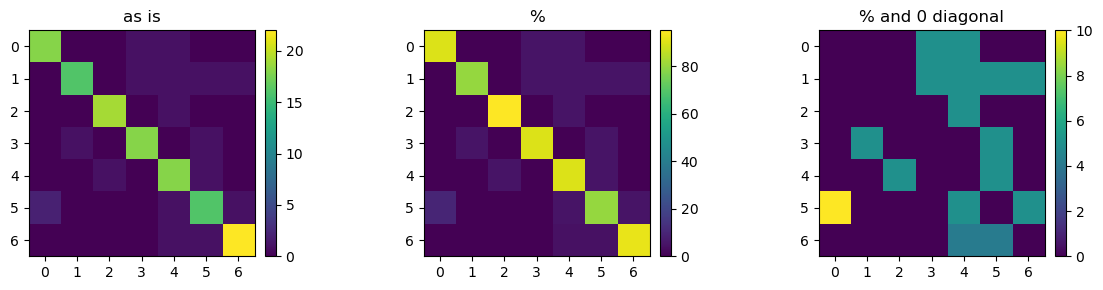


 ['Bear', 'Chicken', 'Deer', 'Eagle', 'Elephant', 'Monkey', 'Panda']


In [21]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
 
def plot_confusion_matrix(cmx, vmax1=None, vmax2=None, vmax3=None):
    cmx_norm = 100*cmx / cmx.sum(axis=1, keepdims=True)
    cmx_zero_diag = cmx_norm.copy()
 
    np.fill_diagonal(cmx_zero_diag, 0)
 
    fig, ax = plt.subplots(ncols=3)
    fig.set_size_inches(12, 3)
    [a.set_xticks(range(len(cmx)+1)) for a in ax]
    [a.set_yticks(range(len(cmx)+1)) for a in ax]
         
    im1 = ax[0].imshow(cmx, vmax=vmax1)
    ax[0].set_title('as is')
    im2 = ax[1].imshow(cmx_norm, vmax=vmax2)
    ax[1].set_title('%')
    im3 = ax[2].imshow(cmx_zero_diag, vmax=vmax3)
    ax[2].set_title('% and 0 diagonal')
 
    dividers = [make_axes_locatable(a) for a in ax]
    cax1, cax2, cax3 = [divider.append_axes("right", size="5%", pad=0.1) 
                        for divider in dividers]
 
    fig.colorbar(im1, cax=cax1)
    fig.colorbar(im2, cax=cax2)
    fig.colorbar(im3, cax=cax3)
    fig.tight_layout()
    
    plt.show()
     
plot_confusion_matrix(cmx)
print('\n', sorted(np.unique(y_test)))

Чтобы сделать правильные выводы, нам необходимо объединить то, что мы видим в матрице неточностей, с тем, что мы уже знаем о данных. Например, у нас довольно высокий процент орлов, отнесенных к курицам. Не в обиду ни орлам, ни курицам, но внутри этого набора они похожи. Кроме того, не все фотографии очень четкие, поэтому, возможно, мы могли бы изучить другие методы выделения признаков или использовать изображения с более высоким разрешением.

Попробуем объединить всё в один конвейер.

In [22]:
from sklearn.pipeline import Pipeline
from sklearn import svm
 
HOG_pipeline = Pipeline([
    ('grayier', RGB2GrayTransformer()),
    ('hogier', HogTransformer(
        pixels_per_cell=(14, 14), 
        cells_per_block=(2, 2), 
        orientations=9, 
        block_norm='L2-Hys')
    ),
    ('scaler', StandardScaler()),
    ('classier', SGDClassifier(random_state=42, max_iter=1000, tol=1e-3))
])
 
clf = HOG_pipeline.fit(X_train, y_train)
accuracy_score(clf.predict(X_test), y_test)

0.8472222222222222

Попробуем оптимизировать нашу модель. Воспользуемся моделью решетчатого поиска.

In [23]:
from sklearn.model_selection import GridSearchCV
 
param_grid = [
    {
        'hogier__orientations': [8, 9],
        'hogier__cells_per_block': [(2, 2), (3, 3)],
        'hogier__pixels_per_cell': [(8, 8), (10, 10), (12, 12)]
    },
    {
        'hogier__orientations': [8],
         'hogier__cells_per_block': [(3, 3)],
         'hogier__pixels_per_cell': [(8, 8)],
         'classier': [
             SGDClassifier(random_state=42, max_iter=1000, tol=1e-3),
             svm.SVC(kernel='linear')
         ]
    }
]

grid_search = GridSearchCV(HOG_pipeline, param_grid, 
                           cv=3, n_jobs=-1,
                           scoring='accuracy',
                           verbose=1,
                           return_train_score=True)
 
grid_res = grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 14 candidates, totalling 42 fits


In [24]:
# сохраним модель на диск
joblib.dump(grid_res, '../../data/hog_sgd_model.pkl');

In [25]:
print(grid_res.best_params_, grid_res.best_score_)

{'classier': SVC(kernel='linear'), 'hogier__cells_per_block': (3, 3), 'hogier__orientations': 8, 'hogier__pixels_per_cell': (8, 8)} 0.9055754569670249


In [26]:
best_pred = grid_res.predict(X_test)
accuracy_score(best_pred, y_test)

0.9444444444444444

Да, мы значительно улучшили показатель правильности ответов модели. Но что нам покажет матрица неточностей?

Стохастический градиентный спуск


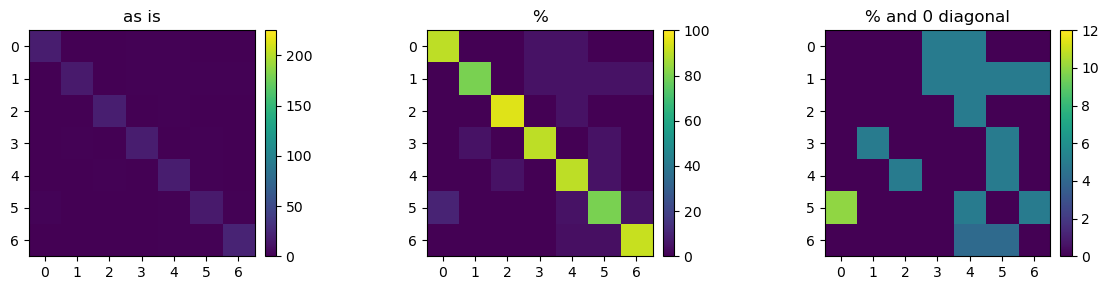

Модель опорных векторов


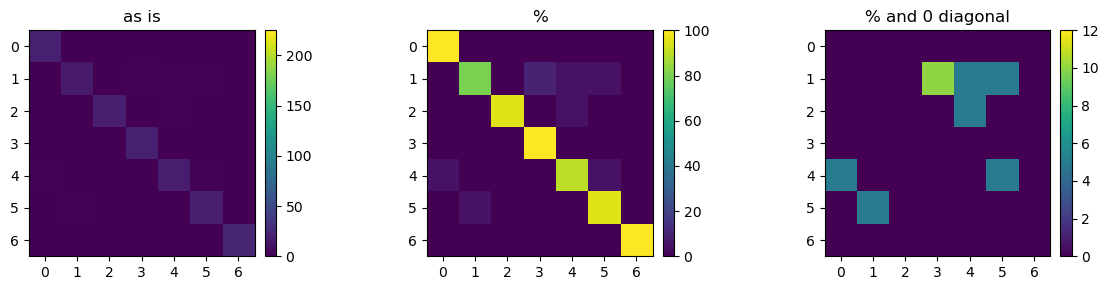

In [27]:
cmx_svm = confusion_matrix(y_test, best_pred)
print("Стохастический градиентный спуск")
plot_confusion_matrix(cmx, vmax1=225, vmax2=100, vmax3=12)
print("Модель опорных векторов")
plot_confusion_matrix(cmx_svm, vmax1=225, vmax2=100, vmax3=12)

Справа мы видим, где произошли улучшения (кажется, мы превратили кур в орлов). Теперь мы можем попытаться найти конкретные проблемы в данных или извлечь признаки для дальнейшего улучшения. К счастью, с помощью созданного нами набора инструментов мы можем позволить компьютеру выполнить за нас значительную часть этой работы.